In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install jsonlines

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(appName="YourTest", master="local[*]")
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
import jsonlines
from pyspark.sql.functions import explode,col
from pyspark.sql import functions as F
from pyspark.sql.functions import concat_ws
import pandas as pd

In [11]:
# Plot Libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [12]:
# Data Path
data_path ="/content/drive/My Drive/UWaterloo/Fall 21/CS 631/Project/sample.jsonl"
data = sqlContext.read.json(data_path).sort("year",ascending=False)
data.count()

50000

In [51]:
# Main Tables Used for visuals

# Main authors data
authors_data = data.select("id",explode("authors").alias("authors"))
authors_data = authors_data.select(authors_data.id.alias("paper_id"), \
    F.col("authors").getItem("name").alias("name"), \
    F.col("authors").getItem("country").alias("country"), \
    F.col("authors").getItem("id").alias("author_id"), \
    F.col("authors").getItem("affiliation").alias("affiliation"), \
    F.col("authors").getItem("affiliationid").alias("affiliationid"), \
    F.col("authors").getItem("order").alias("order"))

# Removing authors with less than 5 papers
authors_valid = authors_data.groupBy("author_id").agg(F.count("paper_id")).filter(col("count(paper_id)")>5)
authors_data = authors_data.join(authors_valid,on="author_id",how="leftsemi")

# Topics per Author
authors_topics = authors_data.join(data.select("id","topics"),authors_data.paper_id==data.id,"left")\
            .select("author_id",explode("topics").alias("topics"))\
            .groupBy(["author_id","topics"]).count()


# Author Stats
# Review g-index and fix h-index
from pyspark.sql.window import Window
windowSpec  = Window.partitionBy("author_id").orderBy(col("citationcount").desc())
authors_stats = authors_data.join(data.select("id","citationcount"),authors_data.paper_id==data.id,"left")\
                            .withColumn("h_index",F.when(F.dense_rank().over(windowSpec)<=col("citationcount"),1).otherwise(0))\
                            .groupBy("author_id")\
                            .agg(F.first("name").alias("name"),\
                                F.first("country").alias("country"),\
                                F.first("affiliation").alias("last_affiliation"),\
                                F.count("paper_id").alias("papers_count"), \
                                F.avg("order").alias("avg_order"),\
                                F.avg("citationcount").alias("avg_citations"),\
                                F.sum("citationcount").alias("total_citations"),\
                                F.sum("h_index").alias("h_index"),\
                                F.first("paper_id").alias("last_paper_id"),\
                                F.collect_list("paper_id").alias("all_paper_id"))\
                            .sort("h_index",ascending=False)

# Coauthors
coauthors_data = authors_data.select("paper_id","author_id")\
            .join(data.select("id",explode("authors").alias("authors")),authors_data.paper_id==data.id,"left")\
            .select("paper_id", "author_id",\
                    F.col("authors").getItem("id").alias("coauthors_ids"),\
                    F.col("authors").getItem("country").alias("country"))\
            .groupBy(["author_id","coauthors_ids","country"]).count()

# Map Data
map_data = px.data.gapminder().query("year==2007")[["iso_alpha","country","continent"]]


# Average Data
avg_data = authors_stats.select("papers_count","avg_order","avg_citations","total_citations","h_index")\
     .agg(F.avg("papers_count").alias("papers_count"),\
          # F.avg("avg_order").alias("avg_order"),\
          F.avg("total_citations").alias("total_citations"),\
          F.avg("avg_citations").alias("avg_citations"),\
          F.avg("h_index").alias("h_index"))\
     .toPandas()

In [52]:
# Filters
# List of distinct countries
countries = authors_data.select("country").distinct().toPandas()

# Selected Country
selected_country = "Canada"

# List of Authors to Select From
authors = authors_data.filter(col("country")==selected_country).select("author_id","name").toPandas()

# Selected Author ID
selected_author = 688402840

In [53]:
def word_cloud_author(author_id):
  topics = authors_topics.filter(col("author_id")==author_id)\
                .select("topics","count")\
                .sort("count",ascending=False).limit(30).toPandas()
  d = {}
  for a, x in topics.values:
      d[a] = x

  wordcloud = WordCloud(width = 1000, height = 1000,
                  background_color ='white',
                  min_font_size = 10)# stopwords = stopwords,
  wordcloud.generate_from_frequencies(frequencies=d)
  plt.figure(figsize = (10, 10), facecolor = None)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.tight_layout(pad = 0)
  plt.axis("off")
  plt.show()

def world_map_authors(author_id):
  map_data = px.data.gapminder().query("year==2007")[["iso_alpha","country","continent"]]
  colabs = coauthors_data.filter(col("author_id")==author_id)\
            .groupBy(["country"]).agg(F.count("author_id").alias("count of authors"))\
            .toPandas()
  colabs = colabs[1:].merge(map_data,how="left").dropna()
  fig = px.scatter_geo(colabs, locations="iso_alpha",color="continent",
                      hover_name="country",size="count of authors")
  fig.show()


# Author_vs_Average 
# summary = authors_stats.filter(col("author_id")==selected_author).toPandas() Used in the next three graphs
# Takes time to filter each time
def avg_bar_authors(author_id):
  summary = authors_stats.filter(col("author_id")==author_id).toPandas()
  fig = make_subplots(rows=1, cols=5)
  i = 1;flag = True
  for label in avg_data.columns: 
    fig_1 = go.Figure(data=[
                  go.Bar(name='Average', x=[label], y=[avg_data[label].iloc[0]],
                        marker_color='red',showlegend=flag),
                  go.Bar(name='Selected Author', x=[label], y=[summary[label].iloc[0]],
                        marker_color='blue',showlegend=flag)
                  ])
    fig.add_trace(fig_1["data"][0],row=1,col=i)
    fig.add_trace(fig_1["data"][1],row=1,col=i)  
    i=i+1
    flag = False

  fig.update_layout(height=600, width=1000, title_text="Author's Stats Compared to Average")
  fig.show()

def table_author_papers(author_id):
  summary = authors_stats.filter(col("author_id")==author_id).toPandas()
  df = data.filter(col("id").isin(summary["all_paper_id"].iloc[0]))\
           .select("papertitle","citationcount","topics","year","doi","urls")\
           .toPandas()
  fig = go.Figure(data=[go.Table(
      header=dict(values=["Title","Citation Count","Topics","Year","Doi","Url"],
                  fill_color='paleturquoise',
                  align='left'),
      cells=dict(values=[df.papertitle,df.citationcount,df.topics.apply(lambda x: ', '.join(map(str, x))),df.year,df.doi,df.urls],
                fill_color='lavender',
                align='left'))
  ])

  fig.show()

def papers_per_year(author_id):
  summary = authors_stats.filter(col("author_id")==author_id).toPandas()
  df = data.filter(col("id").isin(summary["all_paper_id"].iloc[0]))\
            .groupBy("year").count()\
            .toPandas()
  df['year'] = pd.DatetimeIndex(df['year']).year
  years = pd.DataFrame({'year':range(df.year.min(), df.year.max())})
  df = df.merge(years, how='outer').fillna(0).sort_values("year")
  df = df.rename(columns={"year": "Year", "count": "Number of Papers"})

  fig = px.line(df, x="Year", y="Number of Papers")
  fig.show()

# ToDo
# # Stats and Facts
  # print(f"{summary["name"]} was last affilicated with {summary["last_affiliation"]}, \
  #     they have been active since {summary["year"]} till {summary["year"]}") 

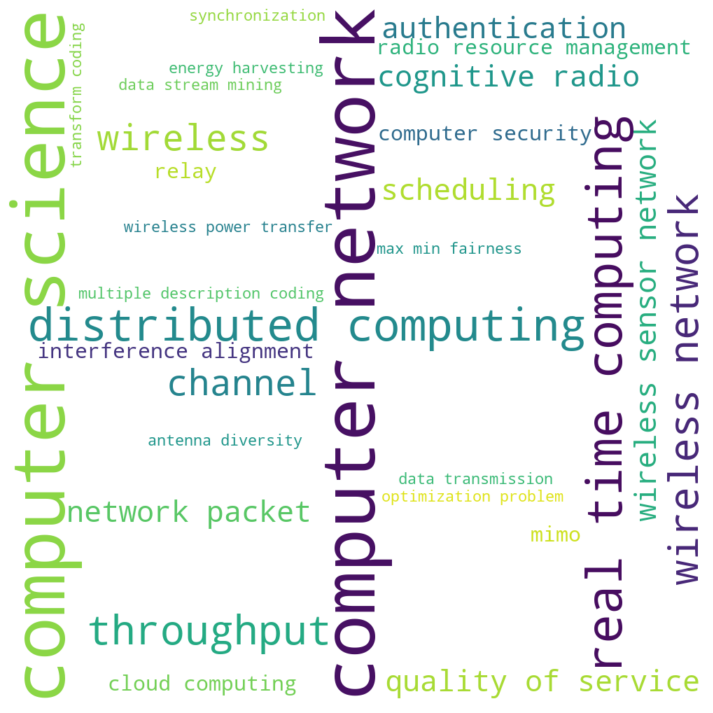

In [54]:
# Tests
word_cloud_author(selected_author)
world_map_authors(selected_author)
avg_bar_authors(selected_author)
table_author_papers(selected_author)
papers_per_year(selected_author)